In [1]:
from toolz import *

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

# The Difference-in-Diferences Saga

After discussing treatment effect heterogeneity, we will now switch gears a bit, back into average treatment effects. Over the next few chapters, we will cover some recent developments in panel data methods. To motivate that, we will mostly talk about causal inference applications to marketing. Markting is particurlaly interesting for its notorious dificulty in runing randomized experience. In marketing, we often can't control who recieves the treatment, that is, who sees our advertisements. When a new user comes to our site or downloads our app, we have no good way of knowing if that user came because he or she saw one of our campaings or due to some other factor. (OBS: For those more familiar with marketing attribution, I'm aware of the many attribution tools that aims at solving this problem. But I'm also aware of their many limitations). Because of that, a common practice is Geo-Experiments: we deploy a marketing campaing to some geografical region but not others and compare them. In this design panel data methods are very promissing. Particularly popular among those is the Diff-in-Diff (DiD) method.

The years 2020 and 2021 have not been easy for most of us. But it was a particularly hard for DiD. A lot of recent research hilighted some severe flaws in this method, which was not well known in the past. So, although we already have a chapter in Part I covering DiD, that chapter does not cover the new findings, problems and solutions. Hence, we will try to make sense of the recent DiD revolution covering in 3 acts:

1. **Promise**: Recap why panel data is so attractive for causal inference and how DiD leverages the temporal structure in its favor. 
2. **Death**: Digest the assumptions implied by DiD and Two Way Fixed Effect models and where and why they can fail.  
3. **Elightment**: Understand which assumptions in the previous act can be relaxed and which ones can't. By doing so, we should have a clear picture on where we can use DiD and where do we need other methods.


## 1) The Promise of Panel Data


Panel data is when we have multiple units `i` over multiple periods of time `t`. Think about a policy evaluation scenario in the US, where you want to check the effect of cannabis legalization on crime rate. You have crime rate data on multiple states `i` over multiple time perios `t`. You also observe at what point in time each state adopts legislation in the direction of canabis legalization. I hope you can see why this is incredibly powerfull for causal inference. Call canabis legalization the treatment `D` (since `T` is taken; it represents time). We can follow the trend on crime rates for a particular state that eventually gets treated and see if there are any disruptions in the trend at the treatment time. In a way, a state serves as its own control unit, in a sort of before and after comparisson. Furthermore, becase we have multiple states, we can also compare treated states to control states. When we put both comparissons toguether, treated vs control and before and after treatement, we end up with an incredibly powerfull tool to infer counterfactuals and, hence, causal effects. 

Panel data methods are often used in govenment policy evaluation, but we can easily make an argument about why it is also incredibly usefull for the (tech) industry. Companies often track user data across multiple periods of time, which results in a rich panel data structure. To expore that idea further, let's consider a hypothetical example of a young tech company that traks its install across multiplies cities. At some point in 2021, the tech company lounched a new feature and it wants how many new uses that feature brought to the company. The rolout was gradual. Some cities got the feature in `2021-06-01`. Others, in `2021-07-15`. The full rolot to the rest of the cities only hapened in 2022. Since our data only goes up untill `2021-07-31`, this last groups can be considered the control. In causal inference terms, roling out a feature is the treatment and each of the three groups (treated in `2021-06-01`, treated in `2021-07-15` and control) is called a cohort. A cohort is simply a bunch of units that got treated at the same time period. To get a sense of what this data looks like, lets plot daily installs grouped by cohort.

In [2]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    post = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    treat_post = lambda d: d["treat"]*d["post"],
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat_post"] == 1, d["y1"], d["y0"])
)


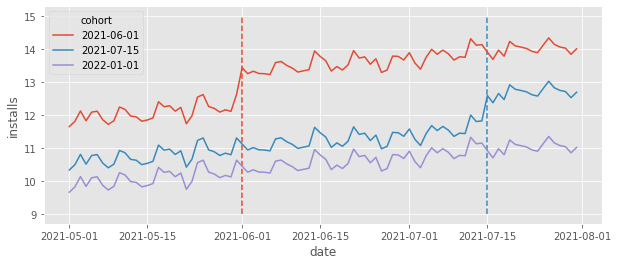

In [3]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

The dashed lines mark the moment a cohort got the treatment (the feature was roled out) Take a momen to appreciate the richness of the data depicted in the above plot. First, we can see that each cohort have its own baseline level. Thats simply because different cities have different population sizes, leading to more or less installs acordingly. For instance, it looks like cities in the first cohort (treated in 06/01) have a higher baseline, compared to the other cohorts. Also, it looks like the control have a lower baseline installs. This means that simply comparing treated cohorts to control cohorts would yield a biased result, since $Y_{0}$ for the control is lower than the $Y_{0}$ for the treated. Fortunatly, panel data allow us to compare acorss cities **and** time.

Speaking of time, notice how there is an overall upward trend with some wigles (which look like weekly seasonality). Looking at the control, it looks like daily installs went from about 10 in May to about 11 in Jun, a increase in about 1 unit. In technical terms, latter time periods have higher $Y_{0}$ than early time periods. So, simply comparing the same cities across time would also yield in biased results. Once again, we are fortunate that the pannel data structure allow us to compare not only across time, but also across cities. 

Ideally, to infer the effect of the feature rolout, we want is to know what would have happened to the cohorts that that got the feature, had they not get it. We want to estimate the counterfactual outcome $Y(0)$ in the post treatment periods. If we denote each cohort by the time it got treated `g` (remember that a cohort is just a group of cities that got treated at the same time), we can write this counterfactual as $E[Y_0|t\geq g]$, which would then allow us to estimate the treatment effect on the treated (the ATT) for cohort `g` as folows:

$$
E[Y_1|t \geq g] - E[Y_0|t\geq g]
$$


Well, one way we can exploit the power of the panel data structure and estimate those counterfactuals if by using linear regression and the Diff-in-Diff formulation we get using a Two Way Fixed Effect model. Let's say each city `i` has a base install level $\gamma_i$. That ties back to what we saw earliers that, maybe a city has more installs because it has a bigger population, or because its culture is more in line with the product from out tech company. Regarthless of the reason and even if we don't know why, we say that those unit idiosincrasies can be captured by a time fixed parameter $\gamma_i$. Similarly, we can say that each time period `t` has a baseline install level which we can capture by a unit fixed parameter $\theta_t$. If that is the case, a good way of modeling install is to say it depends on the city (unit) effect $\gamma$ and the time effect $\theta$, plus some random noise.

$$
Installs_{it} = \gamma_i + \theta_t + e_{it}
$$

To include the treatment in this picture, lets define a variable $D_{it}$ wich is 1 if the unit is treated. In our example, this variable would be always zero for the never treated cohort. It would also be zero for all the other cohorts at the begining, but it would turn into 1 at 06/01 for the cohort treated in 06/01 and stay on after that. Also, it would turn into 1 at 07/15 for the cohort treated in 07/15. We can include those treatment indicators in our model of installs as follows:

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

Estimating the above model is OLS is what is called the Two-Way Fixed Effects Models (TWFE). Notice that $\tau$ would be the treatment effect, as it tells us how much installs changes once units are treated.


Another way of looking at it is to invoke the "holding things constant" propriety of linear regression. If we estimate the above model, we could read the estimate of $\tau$ as how much installs would change if we flip the treatment from 0 to 1 while holding the unit `i` and time `t` fixed. Take a minute to appriciate how bold this is! To say we would hold each unit fixed while seeng how $D$ changes the outcome is to say we are controling for all unit specific characteristic, known and unknown. For example, we would be controling for cities baseline install level, wich we could measure, but also stuff we have no idea about, like how much a city culture is in line with our produt... The only requirement is that this caracteristic is fixed over the time of the analysis. Moreover, to say we would hold each time period fixed is to say we are controlling for all year specifit characteristic. For instance, since we are holding year fixed, while looking at the effect of $D$, that trend and seasonalities we saw earlies would vanish.

To see all this power in action all we have to do is run an OLS model with the treatment indicator $D$ (`treat_post` here), plus dummies for the units and time. In our particular example, I've generated data in such a way that the effect of the treatment (new feature) is to increase installs by 1. Notice how TWFE nais in recovering that treatment effect perfectly:

In [4]:
formula = f"""installs ~ treat_post + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["treat_post"]

1.0000000000000533

Since I've simulated the data above, I know exactly the true individual treatment effect, which is stored in the `tau` column. Since the TWFE should recover the treatment effect on the treated, we can verify that the true ATT matches the one estimated above. 

In [5]:
df.query("treat_post==1")["tau"].mean()

1.0

Before anyone comes and say that generating one dummy column for each unit is impossible with big data, let me come foreward and tell you that, yes, that is true. But there is a easy work around. We can use the FWL theorem to partition that single regression into two. In fact, runing the above model is numerically equivalent to estimating the following model

$$
\tilde{Installs}_{it} = \tau \tilde D_{it} + e_{it}
$$

where 

$$
\tilde{Sales}_{it} = Sales_{it} - \underbrace{\frac{1}{T}\sum_{t=0}^T Sales_{it}}_\text{Time Average} - \underbrace{\frac{1}{N}\sum_{i=0}^N Sales_{it}}_\text{Unit Average}
$$

and

$$
\tilde{D}_{it} = D_{it} - \frac{1}{T}\sum_{t=0}^T D_{it} - \frac{1}{N}\sum_{i=0}^N D_{it}
$$

In words now, in case the math is too crowded, we subtract the unit average across time (first term) and the time average across units (second term) from both the treatment indicator and the outcome variable to constrict the residuals. This process is often times called de-meaning, since we subtract the mean from the outcome and treatment. Finally, here is the same exact thing, but in code:

In [6]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})


formula = f"""installs ~ treat_post"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat_post"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.4580,6.12e-16,-1.87e+16,0.000,-11.458,-11.458
treat_post,1.0000,1.54e-15,6.48e+14,0.000,1.000,1.000


Another thing we can do to understand what TWFE model is doing is to plot the counterfactual predictions $\hat{Y_0}|t \geq g$. This is helpfull because what our model sees as the treatment effect $\hat{\tau}$ as simply the estimated difference $Y_1 - \hat{Y_0}$. Looking at this explicit difference can shed some light on what the model is doing. In the plot below, we can see exactly that, $\hat{Y_0}$ represented by dotted lines. 

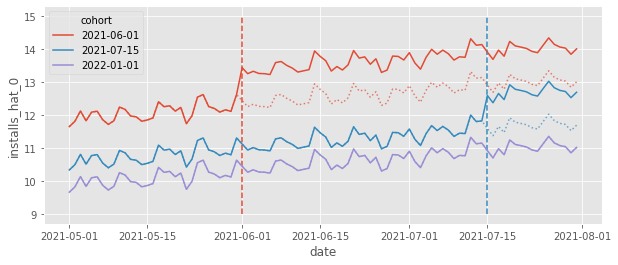

In [7]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat_post":0}))})
          

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    hue="cohort",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

This plot shows us how TWFE is projecting the trend it sees in the control units on the treated units and it is also adjusting the levels. For example, if we look at the red cohort, the counterfactual $Y_0$ is the average trend from the blue and purple cohorts (trend projection) but shifted to the level of the red cohort (level adjustment). This is why we see TWFE as a Difference-in-Differences method. It also does the trend projection and level adjustment, but it workd for multiple time periods and multiple units (in the 2 units by 2 period case, both are equivalent). 


## 2) Death: Assuptions and It's Failures


As we just saw, DiD and TWFE has its merits. It can estimate counterfactuals quite well, acomodating both time and unit specifit variation. This makes it a powerfull causal inference tecnique. But if this was all there was to it, we would't need this chapter, as this is very much covered in Part I of this book. What happened recently is that many academics noticed that extending the 2 by 2 DiD to multiple periods with TWFE is not as straightforeward as we thought before. In fact, TWFE turns out to be biased in many real life application. This even caused a wave of revisions in multiple studies in economics that relied on this technique. To understand all of that, the best way to start is by stating the underling assuption of TWFE and examine when they can fail. 

For simplicity sake (and to make the DAG easier to draw), lets consider the FE model without the time effects:

$$
y_{it} = \tau D_{it} + \gamma_i + e_{it}
$$


Here are the assuptions this model makes. We can group them into two kinds.

1. Functional Form Assuptions:
    * No heterogeneous effects in time (constant effects);
    * Linearity in the covariates;
    * Additive fixed effects.
2. Strick Exogeneity
    * Parallel trends
    * No antecipation
    * No unobserved time varing confounders
    * Past treatment don't affect current outcome (no caryover)
    * Past outcome don't affect current treatment (no feedback)
    

First, let's discuss the functional form assumptions. Linearity in the covariates is very well known and applies to all linear regression model. But, as we saw with the chapter on Double/Debiased Machine Learning, we can easily relax that assumption with a machine learnng model, so I won't spend time on it. As for the additive fixed effect, this is not a too restrictive assumption, so it doesn't cause a lot of problems. The one I want to focus (and which generated a lot of fuss) is the no heterogeneous effects in time assumption.

### Treatment Effect Heterogeneity in Time

If you ever worked with marketing or tech, you know things take time to mature. If you lounch a new feature, it will take time for users to get used to it. Similarly, if you start a maketing campaing, the effect of that campaing won't be instantaneous. It will mature over time and perhaps bring new users even after the campaing is over. This is **not** what we had in installments data we've seen earliers. There, instllments jump up instantenously, at the moment the cohort is treated. What happens if we change that to be more in line with what we see in reality. Namely, lets make it so that the ATT is still 1, but now, it takes 10 days to mature (so it will be 0.1 at the first treatment day, 0.2 at the second treatment day and so on). Also, I'll reduce the size of the time and unit effects so that the overall trend is easier to see. 

In [8]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date.date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    post = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    treat_post = lambda d: d["treat"]*d["post"],
    y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat_post"] == 1, d["y1"], d["y0"])
)


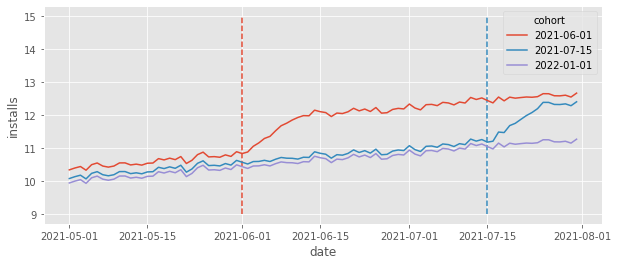

In [9]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_heter
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

Now, what we see is that the installs still reach the same level as they did before, but it takes some time (10 days) for that. This seems reasonable right? Most of the data we see in real life works like that, with effects taking some time to mature. Ok, so let's run TWFE model on this data to see what happens. 

In [10]:
formula = f"""installs ~ treat:post + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_heter).fit()

print("Estimated Effect: ", twfe_model.params["treat:post"])
print("True Effect: ", df_heter.query("treat==1 & post==1")["tau"].mean())

Estimated Effect:  0.7867708225724858
True Effect:  0.8544117647058823


Notice that the true ATT is no longer 1. That is because it will be smaler in the first periods. Regarthless, what we can see is that the **estimated ATT from TWFE is not recovering the true ATT**. In other words, TWFE is biased. But why is that? We have paralel trends, no antecipation and all the other strict exogeneity assumptions here. So what is going on?

The first step towards understanding what is happening is to realize that TWFE can actually be decomposed into multiple 2 by 2 Diff-in-Diff. In our example, thay would be one that compares early treated to never treated, late treated against never treated, early treated agaist late treated (with late treated serving as the control) and late treated against early treated (with early treated being the control):

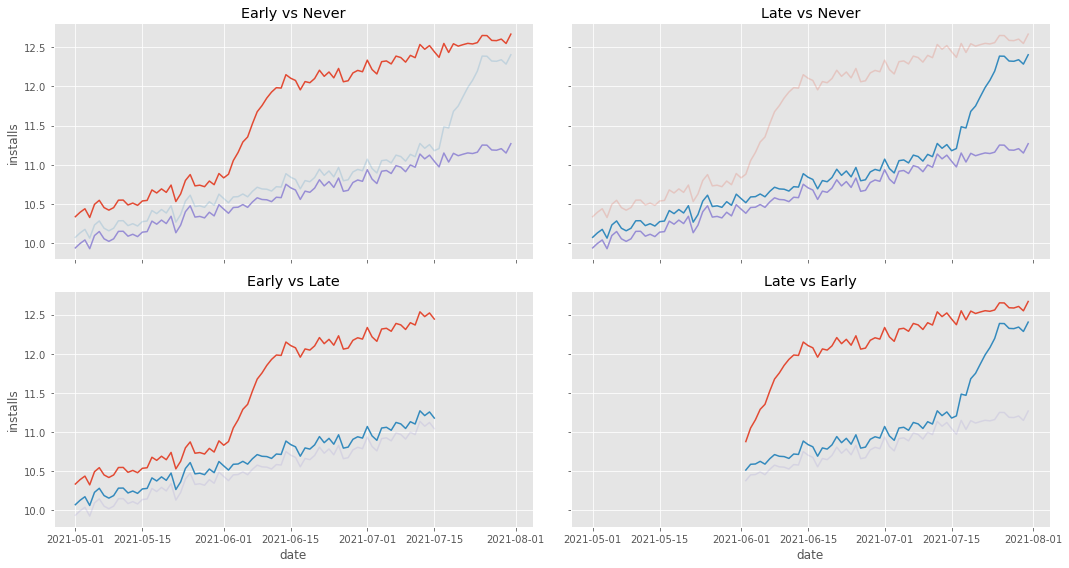

In [11]:
g_plot_data = (df_heter
               .groupby(["cohort", "date"])["installs"]
               .mean()
               .reset_index()
               .astype({"cohort":str}))


fig, axs = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

def plot_comp(df, ax, exclude_cohort, name):
    
    palette=dict(zip(map(str, cohorts), ["C0", "C1", "C2"]))
    
    sns.lineplot(
        data=df.query(f"cohort != '{exclude_cohort}'"),
        x="date",
        y = "installs",
        hue="cohort",
        palette=palette,
        legend=None,
        ax=ax
    )

    sns.lineplot(
        data=df.query(f"cohort == '{exclude_cohort}'"),
        x="date",
        y = "installs",
        hue="cohort",
        palette=palette,
        alpha=0.2,
        legend=None,
        ax=ax
    )
    
    ax.set_title(name)

plot_comp(g_plot_data, axs[0,0], cohorts[1], "Early vs Never")
plot_comp(g_plot_data, axs[0,1], cohorts[0], "Late vs Never")


plot_comp(g_plot_data[g_plot_data["date"]<=cohorts[1]], axs[1,0], cohorts[-1], "Early vs Late")
plot_comp(g_plot_data[g_plot_data["date"]>cohorts[0]], axs[1,1], cohorts[-1], "Late vs Early")

plt.tight_layout();

The first three comparisons are no reason for concern, mostly because what they use as control if very well behaved. However, the fourth comparisson, late vs early, is problematic. Notice that this comparison uses the early treated as a control. Also notice that this early treated control has a wierd behavior. It climbs up sharply at the begining. That is a reflection of our ATT not being instantenous, but instead taking 10 days to mature. Intuitivly, we can see that this will mess up the estimation out the counterfactual trend in the DiD, making it steeper than it should be. To vizualise that, we lets plot the counterfactual $Y_0$ for the late treated in this 4th group.

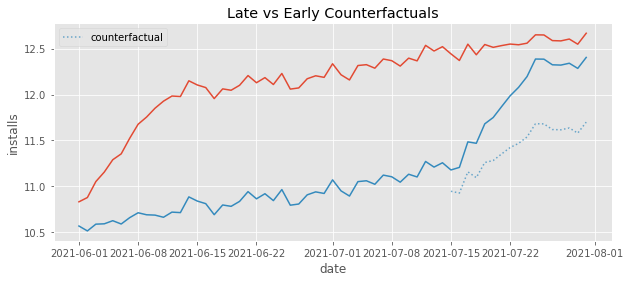

In [12]:
late_vs_early = (df_heter
                 [df_heter["date"].astype(str)>="2021-06-01"]
                 [lambda d: d["cohort"].astype(str)<="2021-08-01"])


formula = f"""installs ~ treat:post + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=late_vs_early).fit()

late_vs_early_pred = (late_vs_early
                      .assign(**{"installs_hat_0": twfe_model.predict(late_vs_early.assign(**{"treat":0, "post":0}))})
                      .groupby(["cohort", "date"])
                      [["installs", "installs_hat_0"]]
                      .mean()
                      .reset_index()
                     )


plt.figure(figsize=(10,4))
plt.title("Late vs Early Counterfactuals")
sns.lineplot(
    data=late_vs_early_pred,
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

sns.lineplot(
    data=(late_vs_early_pred
          [late_vs_early_pred["cohort"].astype(str) == "2021-07-15"]
          [lambda d: d["date"].astype(str) >= "2021-07-15"]
         ),
    x="date",
    y ="installs_hat_0",
    alpha=0.7,
    ls="dotted",
    label="counterfactual"
);

Just like we said, the counterfactuals have a much steeper trend that it shold have. 

More tecnically, it can be shown (Goodman-Bacon, 2019) that, even under strict exogeneity (parallel trends, no antecipation...), if the cohorts have the same size, the TWFE estimator will converge to

$$
plim_{x \to \infty} \hat{\tau}^{TWFE} = VWATT - \Delta ATT
$$

The first term is the variance weighted ATT from multiple DiD comparissons like the ones we saw earlier. This is what we want. However, there is also that extra $\Delta ATT$ term there. This represents how much the ATT changes over time, meaning we will have downard bias if the magnitute of the effect increases (like in our example) or upward bias if the magnitue of the effect decreases. 

In the example above, we saw that the effect from TWFE was smaller than the true ATT. Now, I think is worth going over one last example to see that this bias can be so strong as to even reverse the signal of the true ATT. Lets consider a very simple procees, with only two cohorts, where the treatment effect is negative and decreasing by 0.1 every day. I've also removed all time fixed effects and the trend so we can really see what is going on.

In [13]:
date = pd.date_range("2021-05-15", "2021-07-01", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-06-15"])
units = range(1, 100+1)

np.random.seed(1)

df_min = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
)).assign(
    trend = 0,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    post = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 - d["trend"] + 0.1*d["unit_fe"]
).assign(
    treat_post = lambda d: d["treat"]*d["post"],
    y1 = lambda d: d["y0"] - 0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days))
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat_post"] == 1, d["y1"], d["y0"])
)


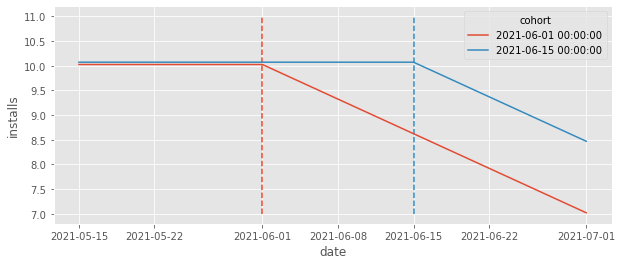

In [14]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_min
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

Looking at the plot above, we can clearly see that the ATT is negative right? However, if we run the TWFE estimator, we get a positive effect!

In [15]:
formula = f"""installs ~ treat_post + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_min).fit()

twfe_model.params["treat_post"]

0.04999999999998828

Once again, to see what is going on, focus your antention on the comparisson where the early treated cohort serves as the control for the late treated. Remember that, like DiD, TWFE adjust trend from the control group to the level of the treated group, so the counterfactual should reflect that. Notice how the counterfactual level is pushed down from where it shouldbe. The fact that the early treat group effect is decreasing pushed this level down from 10 to about 9.5. Not only that, the counterfactual also adjust for a downwad trend, witch should not be there. It is pretty clear from the plot that the right counterfactual should be a straight line at 10, but instead, it is a downward sloping line, since that is what it sees in the early treatrt group it uses as a control. 

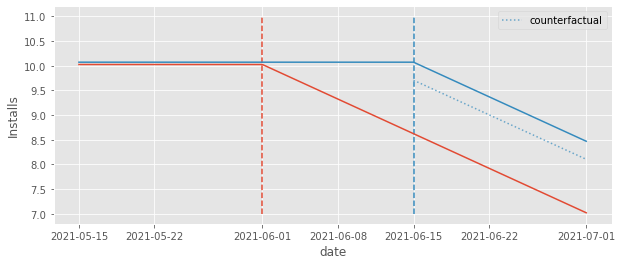

In [16]:
df_pred = df_min.assign(**{"installs_hat_0": twfe_model.predict(df_min.assign(**{"treat_post":0}))})
          
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C1",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

The end result is that the counterfactual $Y_0$ is actually below the $Y_1$ outcome, leading to a positive impact estimation. This is pretty akward, since that, by simply looking at the plot, we can pretty much see where the right counterfactual should be (the straight line at 10). But TWFE cannot recover that simply because it uses the early treated as a control for the late treated. 

#### Event Study Design

Just to get it our of the way, I know someone might think we can easely solve that by what is called an event study design, where add one dummy for each period before and after the treatment. In this case, we replace the orginal TWFE model by

$$
Y_{i,t} = \tau^{-K}~ D_{i,t}^{<-K} + \sum_{k=-K}^{-2} \tau^{lead} D_{i,t}^{k} +\sum_{k=0}^{L} \gamma_k^{lag} D_{i,t}^{k} + \gamma_k^{L+} D_{i,t}^{>L} \gamma_i + e_{it}
$$

where $D^k_{i,t}=1\{t-\text{Cohort}_i=k\}$ is an event study dummy that is 1 if the unit is `k` periods away from the treatment and 0 otherwise. I know this looks messy and complicated, but it is actually very simple once we look at it through some code. All we need to do is create a `relative day` column wich measures how far away is the unit from the period where treatment starts. Then, we create dummies for each of those values. Here is the relative day column along some dummies (I won't show all of them because there is too many). 

In [17]:
df_min_rel = (df_min
              .assign(relative_days = (df_min["cohort"] - df_min["date"]).dt.days)
              .pipe(lambda d: d.join(pd.get_dummies(d["relative_days"], ))))

df_min_rel[["date", "unit", "cohort", "relative_days", -12, -13, 0, 1, 2]].tail()

,date,unit,cohort,relative_days,-12,-13,0,1,2
4795,2021-06-27,100,2021-06-15,-12,1,0,0,0,0
4796,2021-06-28,100,2021-06-15,-13,0,1,0,0,0
4797,2021-06-29,100,2021-06-15,-14,0,0,0,0,0
4798,2021-06-30,100,2021-06-15,-15,0,0,0,0,0
4799,2021-07-01,100,2021-06-15,-16,0,0,0,0,0


If we run this model, the parameter associated with each dummy should measure the effect at that distance from the point where treatment starts. So, we might think that it will capture the time heterogeneity in the ATT and solve all our issues. Unfortunatly, that is not the case. If we do that and plot the counterfactuals, we can see that they are not much better from what we had before. 

In [18]:
relative_days = range(-10,10+1)

formula = f"installs ~" + "+".join([f'Q({c})' for c in relative_days]) + "+ C(date) + C(unit)"

twfe_model = smf.ols(formula, data=df_min_rel).fit()

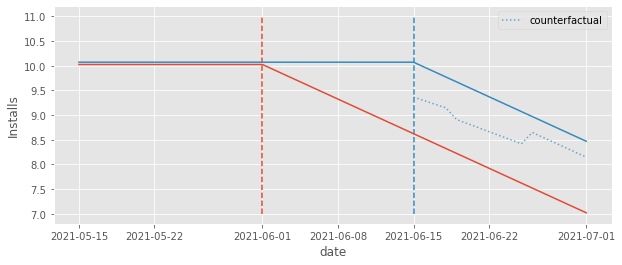

In [19]:
df_pred = df_min_rel.assign(
    installs_hat_0=twfe_model.predict(df_min_rel.replace(to_replace={rday: 1 for rday in relative_days}, value=0))
) 

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C1",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

## Trend in the Effect

### Event Study Desing

In [ ]:
relative_years = range(-10,10+1)

formula = "outcome~"+"+".join([f'Q({c})' for c in relative_years]) + "+C(unit)+C(year)"

mod = smf.ols(formula,
              data=(df_trend_effect.join(pd.get_dummies(df_trend_effect["relative_year"]))))

result = mod.fit()

In [ ]:
ax = (df_trend_effect
      .query("treat==1")
      .query("relative_year>-10")
      .query("relative_year<10")
      .groupby("relative_year")["tau"].mean().plot())

ax.plot(relative_years, result.params[-len(relative_years):]);

## Covariates

## X-Specific Trends

In [ ]:
time = range(1980, 2000)
cohorts = [1990]
units = range(1, 100+1)

np.random.seed(3)

x = np.random.choice(np.random.normal(size=len(units)//10), size=len(units))

df_cov_trend = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
    x = np.repeat(x, len(time)),
)).assign(
    trend = lambda d: d["x"]*(d["year"] - d["year"].min())/20,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = np.repeat(np.random.binomial(1, expit(x)), len(time)),
    y0 = lambda d: 10 + d["trend"] + 0.5*d["unit_fe"] + 0.01*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"]*d["post"] == 1, d["y1"], d["y0"])
)

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_cov_trend.groupby(["treat", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="treat",
);

In [ ]:
facet_col = "x"
all_facet_values = sorted(df_cov_trend[facet_col].unique())
g = sns.FacetGrid(df_cov_trend, col=facet_col, sharey=False, sharex=False, col_wrap=4, height=5, aspect=1)

for x, ax in zip(all_facet_values, g.axes):
    
    plot_df = df_cov_trend.query(f"{facet_col}=={x}")
    
    sns.lineplot(
        data=plot_df.groupby(["treat", "year"])["outcome"].mean().reset_index(),
        x="year",
        y = "outcome",
        hue="treat",
        ax=ax
    )
    
    ax.set_title(f"X = {round(x, 2)}")    

plt.tight_layout()

In [ ]:
formula = f"""outcome ~ treat:post + C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_cov_trend)

result = mod.fit()

result.params["treat:post"]

In [ ]:
formula = f"""outcome ~ treat:post + x * C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_cov_trend)

result = mod.fit()

result.params["treat:post"]

In [ ]:
df_cov_trend.query("treat==1 & post==1")["tau"].mean()